In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
import cv2
import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

from utils import *

In [2]:
j = json.load(open('data/annotations.json'))

In [3]:
j[len(j) - 1]

{'annotations': [{'class': 'fluke',
   'height': 400.70921985815727,
   'type': 'rect',
   'width': 995.035460992911,
   'x': 12.765957446808551,
   'y': 35.46099290780153}],
 'class': 'image',
 'filename': '5a9ce59b1.jpg'}

In [4]:
SZ = 224


# https://github.com/albu/albumentations/blob/master/notebooks/example_bboxes.ipynb

# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
#     x_min, y_min, w, h = bbox
#     x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
#     plt.figure(figsize=(12, 12))
#     plt.imshow(img)
    return img

def get_aug(aug, min_area=0., min_visibility=0.):
    return albumentations.Compose(aug, bbox_params={'format': 'pascal_voc', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['category_id']})



In [5]:
def j2anno(j):
    # bbox coordinates are returned in pascal voc format [x_min, y_min, x_max, y_max]
    im = cv2.imread(f"data/train-{SZ}/{j['filename']}", cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_height, im_width, _ = im.shape
                    
    orig_im = cv2.imread(f"data/train/{j['filename']}", cv2.IMREAD_COLOR)
    orig_im_height, orig_im_width, _ = orig_im.shape

    bbox_info = [anno for anno in j['annotations'] if anno['class'] == 'fluke'][0]
    orig_bbox = [np.clip(bbox_info['x'], 0, orig_im_width), np.clip(bbox_info['y'], 0, orig_im_height), np.clip(bbox_info['x']+bbox_info['width'], 0, orig_im_width), np.clip(bbox_info['y']+bbox_info['height'], 0, orig_im_height)]
    bbox = [orig_bbox[0] * SZ / orig_im_width, orig_bbox[1] * SZ / orig_im_height, orig_bbox[2] * SZ / orig_im_width,  orig_bbox[3] * SZ / orig_im_height]
    return {'image': im, 'bboxes': [bbox], 'category_id': [0]}
                         
cat2name = {0: 'fluke'} # unfortunately this is required by albumentations, we cannot just have bounding box coordinates on their own

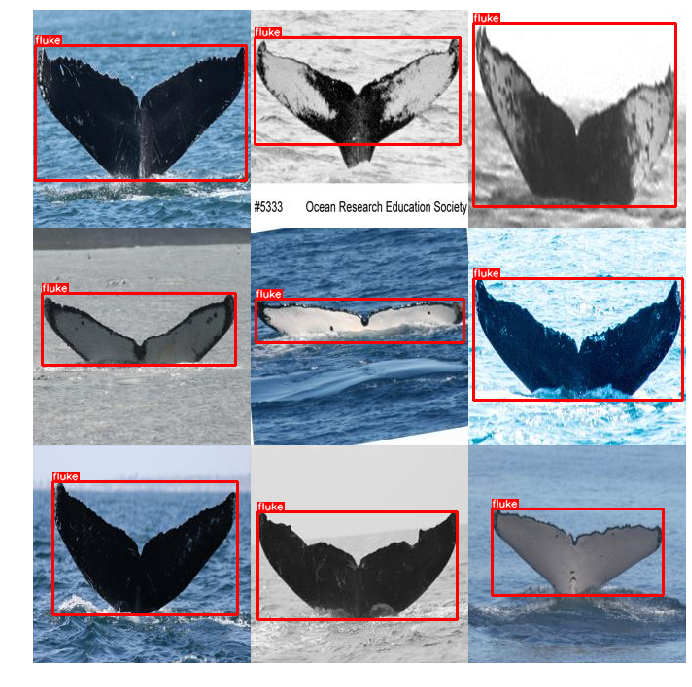

In [6]:
ims = np.stack([visualize(j2anno(j[i]), cat2name) for i in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

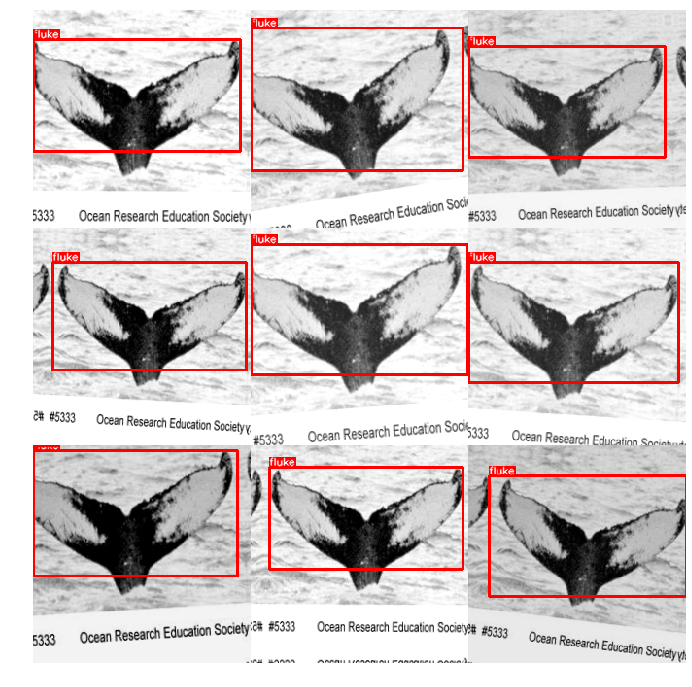

In [7]:
aug = get_aug([albumentations.RandomBrightnessContrast(always_apply=True), albumentations.ShiftScaleRotate(rotate_limit=10, always_apply=True)])

ims = np.stack([visualize(aug(**j2anno(j[1])), cat2name) for _ in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

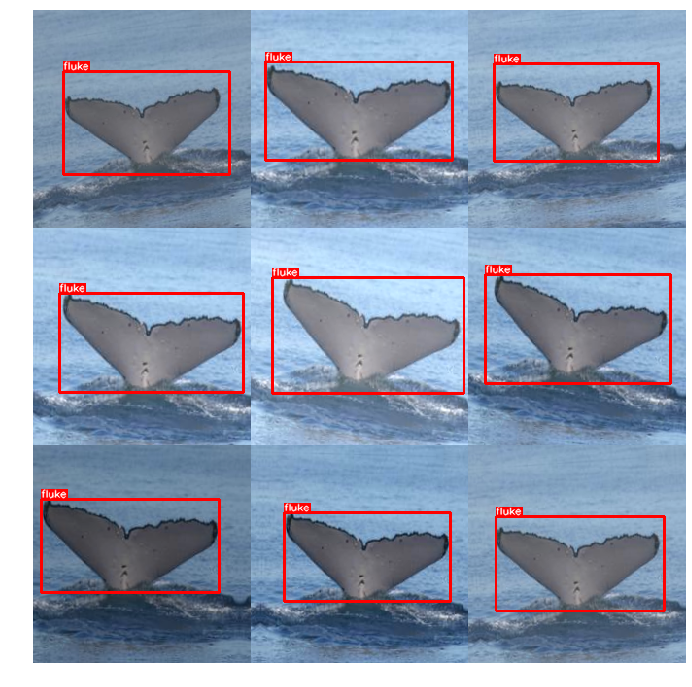

In [8]:
aug = get_aug([albumentations.RandomBrightnessContrast(always_apply=True), albumentations.ShiftScaleRotate(rotate_limit=10, always_apply=True)])

ims = np.stack([visualize(aug(**j2anno(j[8])), cat2name) for _ in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

In [9]:
idxs = np.arange(len(j))
np.random.seed(0)
np.random.shuffle(idxs)
val_idxs = idxs[:100]
# val_idxs = pd.to_pickle(val_idxs, 'data/val_idxs_detection.pkl')

In [10]:
val_j = [anno for i, anno in enumerate(j) if i in val_idxs]
trn_j = [anno for i, anno in enumerate(j) if i not in val_idxs]

In [11]:
len(trn_j), len(val_j)

(900, 100)

In [12]:
pd.to_pickle([anno['filename'] for anno in val_j], 'data/val_fns_detection.pkl') # this will allow me to use the same validation set across NBs

In [13]:


class CustomDataset(Dataset):
    def __init__(self, j, aug=None):
        self.j = j
        if aug is not None: aug = get_aug(aug)
        self.aug = aug
    
    def __getitem__(self, idx):
        item = j2anno(self.j[idx])
        if self.aug: item = self.aug(**item)
        im, bbox = item['image'], np.array(item['bboxes'][0])
        im, bbox = self.normalize_im(im), self.normalize_bbox(bbox)
        
        return im.transpose(2,0,1).astype(np.float32), bbox.astype(np.float32)
    
    def __len__(self):
        return len(self.j)
    
    def normalize_im(self, ary):
        return ((ary / 255 - imagenet_stats[0]) / imagenet_stats[1])
    
    def normalize_bbox(self, bbox):
        return bbox / SZ



In [14]:
trn_ds = CustomDataset(trn_j, [albumentations.RandomBrightnessContrast(always_apply=True), albumentations.ShiftScaleRotate(rotate_limit=10, always_apply=True)])
val_ds = CustomDataset(val_j)


In [15]:
NUM_WORKERS=12
BS = 64

train_dl = DataLoader(trn_ds, BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dl = DataLoader(val_ds, BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

data_bunch = DataBunch(train_dl, valid_dl)

In [16]:


class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return x.sigmoid_()



In [18]:
learn = Learner(data_bunch, FlukeDetector(arch=models.resnet50), loss_func=L1Loss())
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])
learn.freeze_to(-1)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,0.398270,0.359466
2,0.332542,0.094029
3,0.220082,0.092914
4,0.160813,0.068561
5,0.127034,0.067751
6,0.105893,0.061738
7,0.090787,0.054783
8,0.078619,0.044020
9,0.070150,0.047455
10,0.063894,0.045081


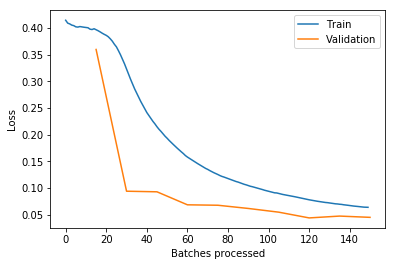

In [19]:
learn.recorder.plot_losses()

In [20]:


def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)



In [21]:
learn.metrics = [lambda preds, targs: IoU(preds, targs).mean()]
learn.validate()

[0.045080952, tensor(0.7706)]

In [22]:
learn.unfreeze()

In [23]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr]

In [24]:
learn.fit_one_cycle(40, lrs, div_factor=20)

epoch,train_loss,valid_loss,
1,0.047058,0.045904,0.766834
2,0.047294,0.042267,0.780663
3,0.045699,0.037984,0.798876
4,0.045019,0.043227,0.775086
5,0.044239,0.042826,0.776821
6,0.043339,0.039022,0.790020
7,0.042843,0.038005,0.796735
8,0.042395,0.042257,0.773863
9,0.043392,0.036956,0.797482
10,0.041971,0.037297,0.796563


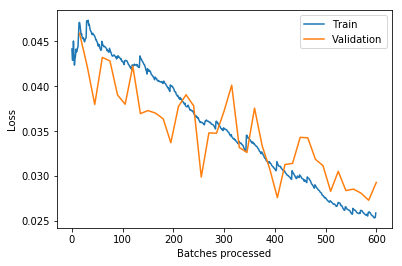

In [25]:
learn.recorder.plot_losses()

In [26]:
preds, targs = learn.get_preds()
predicted_bboxes = ((preds) * SZ).numpy()
targets = ((targs) * SZ).numpy()

In [27]:
def draw_bbox(img, bbox, target=None, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
    return img

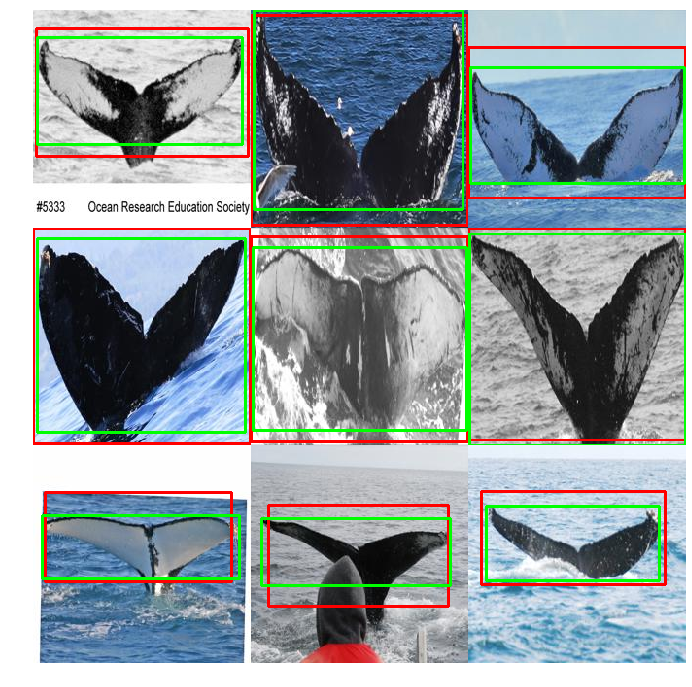

In [28]:


ims = np.stack([draw_bbox(j2anno(val_j[i])['image'], predicted_bboxes[i], targets[i]) for i in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

